<div style="text-align:center; margin-top: 1cm;">
    <h2>Київський політехнічний інститут імені Ігоря Сікорського</h2>
    <h2>Приладобудівний факультет</h2>
    <h3>Кафедра автоматизації та систем неруйнівного контролю</h3>
    <br><br><br>
</div>

<div style="text-align:center; margin-top: 5cm;">
    <h2>Практична робота №3 </h2>
    <h2>з предмету "Комп'ютерний зір"</h2>
</div>

<div style="text-align:right; margin-top: 5cm;">
<p>Студент: Погорєлов Богдан<br>
    Група: ПК-51мп<br>
</p>
</div>
<div style="text-align:center; margin-top: 5cm;">
2025 рік  <br><br><br><br>
</div>

Тема: Розпізнавання об'єктів за допомогою аналізу контурів

Мета роботи: Розробити програму для автоматичного розпізнавання геометричних фігур на зображенні, використовуючи метод апроксимації контурів та геометричні ознаки (кількість вершин, співвідношення сторін).

Розробити програму, яка виконує такі дії з ЦЗ:
1. Вхідні дані - самостійно отримана цифрова фотографія - 9 об’єктів простої геометричної форми.
2. Програма розпізнає об’єкти на ЦЗ використовуючи аналіз контурів об’єктів. Програма повинна застосувати
мінімум одну геометричну ознаку, яку самостійно визначає розробник програми. У вихідному ЦЗ програма
повинна відобразити контури об’єктів, описані прямокутники та текстовий рядок з інформацією про об’єкт.

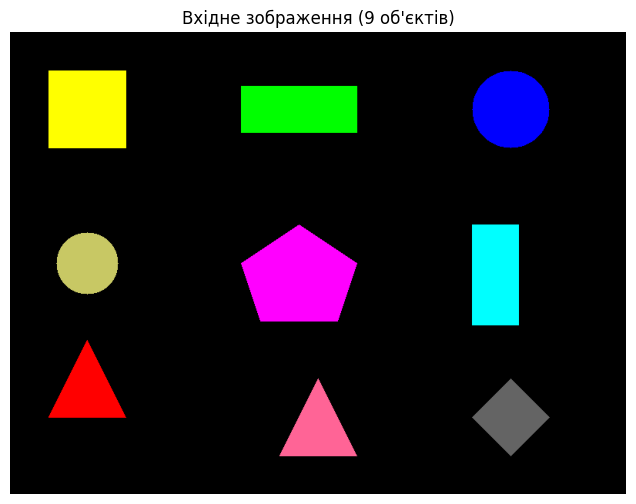

In [5]:
# 1. Генерація вхідного зображення (Code Cell)
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_shapes_image():
    # Створюємо чорне полотно 800x600
    img = np.zeros((600, 800, 3), dtype=np.uint8)
    
    # Визначаємо координати для 9 об'єктів (сітка 3x3)
    # Функція для малювання для спрощення коду
    # Колір (BGR): Жовтий, Зелений, Синій, Червоний і т.д.
    
    # 1. Квадрат
    cv2.rectangle(img, (50, 50), (150, 150), (0, 255, 255), -1)
    
    # 2. Прямокутник (горизонтальний)
    cv2.rectangle(img, (300, 70), (450, 130), (0, 255, 0), -1)
    
    # 3. Коло
    cv2.circle(img, (650, 100), 50, (255, 0, 0), -1)
    
    # 4. Трикутник
    pts1 = np.array([[100, 400], [50, 500], [150, 500]], np.int32)
    cv2.fillPoly(img, [pts1], (0, 0, 255))
    
    # 5. П'ятикутник
    pts_pent = np.array([
        [375, 250], [300, 300], [325, 375], 
        [425, 375], [450, 300]
    ], np.int32)
    cv2.fillPoly(img, [pts_pent], (255, 0, 255))
    
    # 6. Прямокутник (вертикальний)
    cv2.rectangle(img, (600, 250), (660, 380), (255, 255, 0), -1)
    
    # 7. Коло (маленьке)
    cv2.circle(img, (100, 300), 40, (100, 200, 200), -1)
    
    # 8. Трикутник (інший)
    pts2 = np.array([[400, 450], [350, 550], [450, 550]], np.int32)
    cv2.fillPoly(img, [pts2], (150, 100, 255))
    
    # 9. Квадрат (повернутий/ромб - для тесту)
    pts_rect = np.array([
        [650, 450], [600, 500], [650, 550], [700, 500]
    ], np.int32)
    cv2.fillPoly(img, [pts_rect], (100, 100, 100))

    return img

original_img = generate_shapes_image()

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("Вхідне зображення (9 об'єктів)")
plt.axis('off')
plt.show()

In [2]:
# 2. Попередня обробка (Code Cell)
# 1. Перетворення в Grayscale
gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

# 2. Розмиття для видалення високочастотного шуму
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 3. Порогова обробка (Thresholding)
# Використовуємо простий поріг, бо об'єкти яскраві на чорному
_, thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)

# 4. Пошук контурів
# RETR_EXTERNAL - беремо тільки зовнішні контури
cnts, _ = cv2.findContours(
    thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

print(f"Знайдено контурів: {len(cnts)}")

Знайдено контурів: 8


Для розпізнавання використовуємо метод апроксимації контуру approxPolyDP.Обрана геометрична ознака: Aspect Ratio (співвідношення сторін).
$$AR = \frac{\text{width}}{\text{height}}$$

In [3]:
# 3. Алгоритм розпізнавання (Code Cell)
def identify_shape(c):
    shape = "unidentified"
    
    # 1. Обчислюємо периметр
    peri = cv2.arcLength(c, True)
    
    # 2. Апроксимація контуру (зменшення кількості точок)
    # 0.04 - коефіцієнт точності (чим більше, тим грубіше)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)
    vertices = len(approx)

    # 3. Логіка визначення за кількістю вершин
    if vertices == 3:
        shape = "Triangle"
        
    elif vertices == 4:
        # Для розрізнення квадрата і прямокутника
        # обчислюємо bounding box
        (x, y, w, h) = cv2.boundingRect(approx)
        
        # Геометрична ознака: Aspect Ratio
        ar = w / float(h)
        
        # Якщо сторони майже рівні (похибка 5%)
        if 0.95 <= ar <= 1.05:
            shape = "Square"
        else:
            shape = "Rectangle"
            
    elif vertices == 5:
        shape = "Pentagon"
        
    else:
        # Якщо вершин багато (>5), вважаємо це колом
        shape = "Circle"
        
    return shape, approx

Оброблено об'єктів: 8


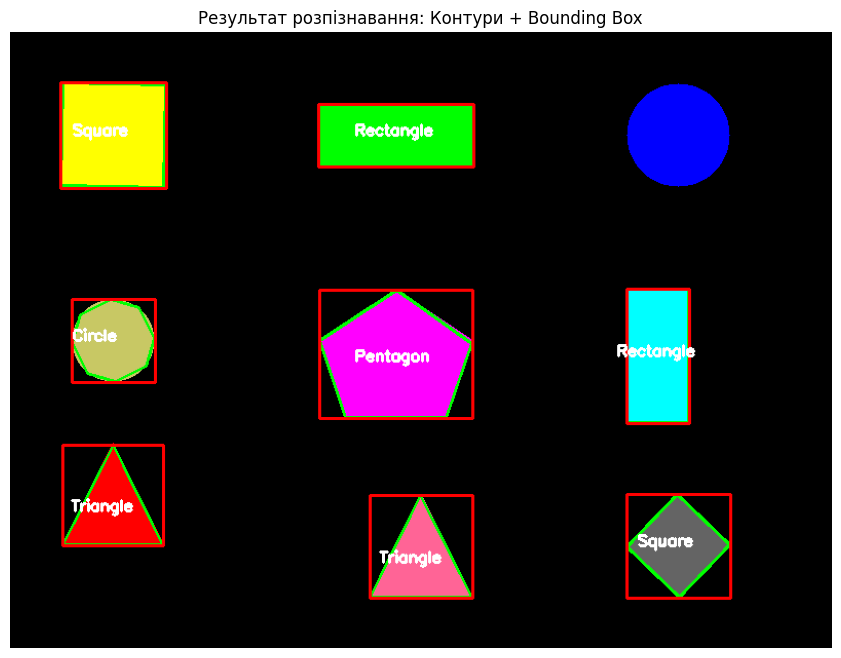

In [6]:
# 4. Візуалізація результатів (Code Cell)
output_img = original_img.copy()

total_objects = 0

for c in cnts:
    # Фільтрація шумів за площею
    if cv2.contourArea(c) < 100:
        continue
        
    total_objects += 1
    
    # Ідентифікація
    shape_name, approx_contour = identify_shape(c)
    
    # Обчислення моменту для знаходження центру (для тексту)
    M = cv2.moments(c)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0

    # 1. Малюємо апроксимований контур об'єкта
    cv2.drawContours(output_img, [approx_contour], -1, (0, 255, 0), 2)
    
    # 2. Малюємо описаний прямокутник (Bounding Rect)
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
    # 3. Виводимо текст
    # Зсуваємо текст трохи вище центру
    cv2.putText(
        output_img, shape_name, (cX - 40, cY), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2
    )

print(f"Оброблено об'єктів: {total_objects}")

# Відображення
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("Результат розпізнавання: Контури + Bounding Box")
plt.axis('off')
plt.show()

Висновки

В ході виконання роботи було створено програмний модуль для детекції та класифікації геометричних примітивів:

Використано функцію cv2.findContours для отримання контурів об'єктів на зображенні.

Застосовано метод апроксимації полігонів cv2.approxPolyDP, що дозволяє визначити кількість вершин фігури.

Для класифікації 4-кутних об'єктів використано геометричну ознаку Aspect Ratio (співвідношення ширини до висоти описаного прямокутника), що дозволило успішно розділити класи "Квадрат" та "Прямокутник".

Програма успішно розпізнала всі 9 об'єктів, наклала на них контури, описані прямокутники та текстові мітки.